# Tutorial: optimal binning with multiclass target

## Basic

To get us started, let's load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [1]:
import pandas as pd
from sklearn.datasets import load_wine

In [2]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the multiclass target.

In [3]:
variable = "ash"
x = df[variable].values
y = data.target

Import and instantiate an ``MulticlassOptimalBinning`` object class. We pass the variable name  and a solver, in this case, we choose the constraint programming solver.

In [4]:
from optbinning import MulticlassOptimalBinning

In [5]:
optb = MulticlassOptimalBinning(name=variable, solver="cp")

We fit the optimal binning object with arrays ``x`` and ``y``.

In [6]:
optb.fit(x, y)

MulticlassOptimalBinning(name='ash')

You can check if an optimal solution has been found via the ``status`` attribute:

In [7]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [8]:
optb.splits

array([2.1450001 , 2.245     , 2.31499994, 2.6049999 , 2.6450001 ])

#### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``OptimalBinning`` returns an object ``MulticlassBinningTable`` via the ``binning_table`` attribute.

In [9]:
binning_table = optb.binning_table

In [10]:
type(binning_table)

optbinning.binning.binning_statistics.MulticlassBinningTable

The `binning_table` is instantiated, but not built. Therefore, the first step is to call the method `build`, which returns a ``pandas.DataFrame``.

In [11]:
binning_table.build()

,Bin,Count,Count (%),Event_0,Event_1,Event_2,Event_rate_0,Event_rate_1,Event_rate_2
0,"(-inf, 2.15)",31,0.174157,7,23,1,0.225806,0.741935,0.032258
1,"[2.15, 2.25)",20,0.112360,2,13,5,0.100000,0.650000,0.250000
2,"[2.25, 2.31)",26,0.146067,9,10,7,0.346154,0.384615,0.269231
3,"[2.31, 2.60)",64,0.359551,24,17,23,0.375000,0.265625,0.359375
4,"[2.60, 2.65)",10,0.056180,4,1,5,0.400000,0.100000,0.500000
5,"[2.65, inf)",27,0.151685,13,7,7,0.481481,0.259259,0.259259
6,Special,0,0.000000,0,0,0,0.000000,0.000000,0.000000
7,Missing,0,0.000000,0,0,0,0.000000,0.000000,0.000000
Totals,,178,1.000000,59,71,48,0.331461,0.398876,0.269663


Let's describe the columns of this binning table:

- Bin: the intervals delimited by the optimal split points.
- Count: the number of records for each bin.
- Count (%): the percentage of records for each bin.
- Event: the number of event records $(y = class)$ for each bin.
- Event rate: the percentage of event records for each bin. This is computed using one-vs-all or one-vs-rest approach.

The last row shows the total number of records, event records, and event rates.

You can use the method ``plot`` to visualize the histogram and event rate curve. Note that the Bin ID corresponds to the binning table index.

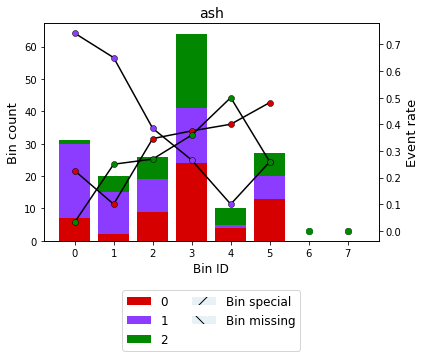

In [12]:
binning_table.plot()

Alternatively, the Bin can be visualized using ``show_bin_labels=True`` (since version 0.15.1)

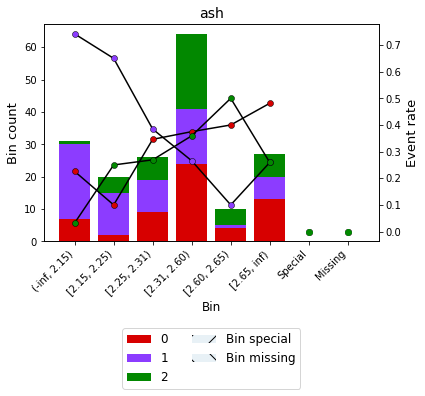

In [13]:
binning_table.plot(show_bin_labels=True)

##### Transformation

Now that we have checked the binned data, we can transform our original data into a measure based on the one-vs-rest WoE metric. You can check the correctness of the transformation using pandas ``value_counts`` method, for instance.

In [14]:
x_transform_woe = optb.transform(x, metric="bins")

In [15]:
pd.Series(x_transform_woe).value_counts()

[2.31, 2.60)    64
(-inf, 2.15)    31
[2.65, inf)     27
[2.25, 2.31)    26
[2.15, 2.25)    20
[2.60, 2.65)    10
dtype: int64

## Advanced

Many of the advanced options have been covered in the previous tutorials with a binary target. **Check it out!** In this section, we focus on the binning table statistical analysis and the event rate monotonicity trends.

#### Binning table statistical analysis

The ``analysis`` method performs a statistical analysis of the binning table, computing the Jensen-shannon divergence and the quality score. Additionally, a statistical significance test between consecutive bins of the contingency table is performed using the Chi-square test.

In [16]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.10989515
    HHI                      0.21973236
    HHI (normalized)         0.10826555
    Cramer's V               0.31694075
    Quality score            0.05279822

  Monotonic trend

    Class  0                     valley
    Class  1                     valley
    Class  2                       peak

  Significance tests

    Bin A  Bin B  t-statistic  p-value
        0      1     6.135081 0.046535
        1      2     4.472669 0.106849
        2      3     1.365275 0.505282
        3      4     1.441642 0.486353
        4      5     2.265477 0.322150



#### Event rate monotonicity

The ``monotonic_trend`` option permits forcing a monotonic trend to the event rate curve of each class. The default setting “auto” should be the preferred option, however, some business constraints might require to impose different trends. The default setting “auto” chooses the monotonic trend most likely to maximize the information value from the options “ascending”, “descending”, “peak” and “valley” for each class using a machine-learning-based classifier.

A good starting point to decide which monotonic trend to enforce for each class is to use ``monotonic_trend=None``. 

In [17]:
optb = MulticlassOptimalBinning(name=variable, solver="mip", monotonic_trend=None)

optb.fit(x, y)

MulticlassOptimalBinning(monotonic_trend=None, name='ash', solver='mip')

In [18]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Event_0,Event_1,Event_2,Event_rate_0,Event_rate_1,Event_rate_2
0,"(-inf, 2.15)",31,0.174157,7,23,1,0.225806,0.741935,0.032258
1,"[2.15, 2.25)",20,0.112360,2,13,5,0.100000,0.650000,0.250000
2,"[2.25, 2.28)",15,0.084270,5,5,5,0.333333,0.333333,0.333333
3,"[2.28, 2.31)",11,0.061798,4,5,2,0.363636,0.454545,0.181818
4,"[2.31, 2.35)",9,0.050562,1,2,6,0.111111,0.222222,0.666667
5,"[2.35, 2.39)",12,0.067416,4,2,6,0.333333,0.166667,0.500000
6,"[2.39, 2.47)",19,0.106742,10,6,3,0.526316,0.315789,0.157895
7,"[2.47, 2.50)",9,0.050562,3,2,4,0.333333,0.222222,0.444444
8,"[2.50, 2.60)",15,0.084270,6,5,4,0.400000,0.333333,0.266667
9,"[2.60, 2.65)",10,0.056180,4,1,5,0.400000,0.100000,0.500000


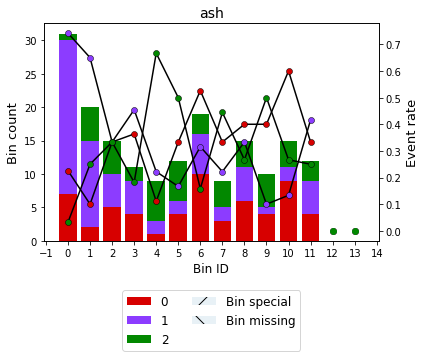

In [19]:
binning_table.plot()

In [20]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.15199204
    HHI                      0.09683121
    HHI (normalized)         0.02735669
    Cramer's V               0.37833165
    Quality score            0.00403065

  Monotonic trend

    Class  0               no monotonic
    Class  1               no monotonic
    Class  2               no monotonic

  Significance tests

    Bin A  Bin B  t-statistic  p-value
        0      1     6.135081 0.046535
        1      2     4.212963 0.121665
        2      3     0.800385 0.670191
        3      4     4.935065 0.084794
        4      5     1.400000 0.496585
        5      6     4.205201 0.122138
        6      7     2.682861 0.261471
        7      8     0.838095 0.657673
        8      9     2.268519 0.321660
        9     10     1.424501 0.490539
       10     11     3.056044 0.216964

For example, we can decide that we do not care about class 2 and only force classes 0 and 1.

In [21]:
optb = MulticlassOptimalBinning(name=variable, solver="mip",
                                monotonic_trend=["ascending", "auto", None],
                                verbose=True)

optb.fit(x, y)

2022-12-15 13:01:52,258 | INFO : Optimal binning started.
2022-12-15 13:01:52,269 | INFO : Options: check parameters.
2022-12-15 13:01:52,271 | INFO : Pre-processing started.
2022-12-15 13:01:52,275 | INFO : Pre-processing: number of samples: 178
2022-12-15 13:01:52,277 | INFO : Pre-processing: number of clean samples: 178
2022-12-15 13:01:52,280 | INFO : Pre-processing: number of missing samples: 0
2022-12-15 13:01:52,282 | INFO : Pre-processing: number of special samples: 0
2022-12-15 13:01:52,284 | INFO : Pre-processing terminated. Time: 0.0002s
2022-12-15 13:01:52,285 | INFO : Pre-binning started.
2022-12-15 13:01:52,292 | INFO : Pre-binning: number prebins removed: 1
2022-12-15 13:01:52,304 | INFO : Pre-binning: number of prebins: 12
2022-12-15 13:01:52,309 | INFO : Pre-binning: number of refinements: 1
2022-12-15 13:01:52,315 | INFO : Pre-binning terminated. Time: 0.0145s
2022-12-15 13:01:52,316 | INFO : Optimizer started.
2022-12-15 13:01:52,319 | INFO : Optimizer: classifier pr

MulticlassOptimalBinning(monotonic_trend=['ascending', 'auto', None],
                         name='ash', solver='mip', verbose=True)

In [22]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Event_0,Event_1,Event_2,Event_rate_0,Event_rate_1,Event_rate_2
0,"(-inf, 2.25)",51,0.286517,9,36,6,0.176471,0.705882,0.117647
1,"[2.25, 2.35)",35,0.196629,10,12,13,0.285714,0.342857,0.371429
2,"[2.35, 2.39)",12,0.067416,4,2,6,0.333333,0.166667,0.500000
3,"[2.39, inf)",80,0.449438,36,21,23,0.450000,0.262500,0.287500
4,Special,0,0.000000,0,0,0,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0,0.000000,0.000000,0.000000
Totals,,178,1.000000,59,71,48,0.331461,0.398876,0.269663


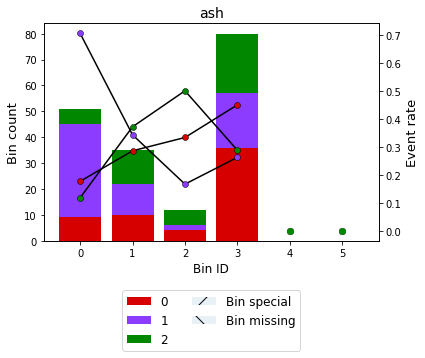

In [23]:
binning_table.plot()

In [24]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.08899633
    HHI                      0.32729453
    HHI (normalized)         0.19275344
    Cramer's V               0.30518651
    Quality score            0.08792312

  Monotonic trend

    Class  0                  ascending
    Class  1            valley (convex)
    Class  2             peak (concave)

  Significance tests

    Bin A  Bin B  t-statistic  p-value
        0      1    12.072711 0.002390
        1      2     1.364733 0.505419
        2      3     2.204828 0.332069



#### Event rate minimum difference

Since version 0.17.0, the parameter ``min_event_rate_diff`` is available for multiclass binning.

In [25]:
optb = MulticlassOptimalBinning(name=variable, solver="mip",
                                monotonic_trend=None,
                                min_event_rate_diff=0.03)

optb.fit(x, y)

MulticlassOptimalBinning(min_event_rate_diff=0.03, monotonic_trend=None,
                         name='ash', solver='mip')

In [26]:
optb.information(print_level=2)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                                 ash   * U
    prebinning_method                   cart   * d
    solver                               mip   * U
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    monotonic_trend                       no   * U
    min_event_rate_diff                 0.03   * U
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    user_splits                           no   * d
    user_splits_fixed                     no   * d
    special_codes                         no   * d
    split_digits                          no   * d
    mip_solver     

In [27]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Event_0,Event_1,Event_2,Event_rate_0,Event_rate_1,Event_rate_2
0,"(-inf, 2.15)",31,0.174157,7,23,1,0.225806,0.741935,0.032258
1,"[2.15, 2.25)",20,0.112360,2,13,5,0.100000,0.650000,0.250000
2,"[2.25, 2.28)",15,0.084270,5,5,5,0.333333,0.333333,0.333333
3,"[2.28, 2.31)",11,0.061798,4,5,2,0.363636,0.454545,0.181818
4,"[2.31, 2.35)",9,0.050562,1,2,6,0.111111,0.222222,0.666667
5,"[2.35, 2.39)",12,0.067416,4,2,6,0.333333,0.166667,0.500000
6,"[2.39, 2.47)",19,0.106742,10,6,3,0.526316,0.315789,0.157895
7,"[2.47, 2.50)",9,0.050562,3,2,4,0.333333,0.222222,0.444444
8,"[2.50, 2.60)",15,0.084270,6,5,4,0.400000,0.333333,0.266667
9,"[2.60, 2.73)",25,0.140449,13,3,9,0.520000,0.120000,0.360000


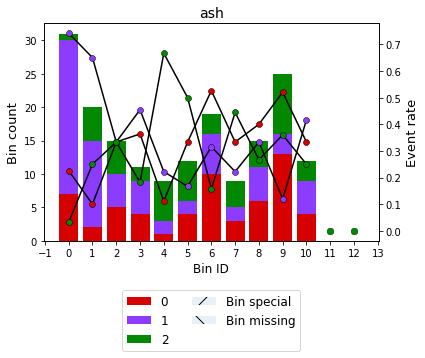

In [28]:
binning_table.plot()